In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
from tqdm import tqdm
import subprocess
from mawkutils.data import KaggleDataSet, DBManager as DBM
from mawkutils.validation import calc_metrics
from mawkutils.render import prettify

IMG_PATH = Path().cwd().parent / 'notebooks' / 'img'
BIN_PATH = Path().cwd().parent / 'data' / "output" / "static_blackbox_estimates"
dataset_path = Path().cwd().parent / "data" / "input" / "measures_v2.csv"
fig_scale = 1.0
pd.set_option('display.max_columns', 500)

In [2]:
PARAM_MAP = {"pm": "PM", "stator_yoke": "SY", "stator_tooth": "ST", "stator_winding": "SW"}
annot_bbox_kws = {'facecolor': 'white', 'edgecolor': 'black',
                      'alpha': 0.3, 'mutation_scale': 1.2}

def show_error_trajectories_4_diss(preds, dataset, sup_title=None, large=True):
    """Error trajectories for dissertation. No Input features, but prediction vs gtruth, error trend, and error histogram.
    Expects preds to be unnormalized and pandas dataframes."""
    assert isinstance(preds, pd.DataFrame), "preds must be pandas DataFrame"
    test_set_l = preds.loc[:, dataset.pid].unique().tolist()
    gtruth_df = dataset.data.query(f"{dataset.pid} in @test_set_l").loc[:, dataset.target_cols].reset_index(drop=True)
    preds_df = preds.loc[:, dataset.target_cols].reset_index(drop=True)
    diff = preds_df - gtruth_df

    error_ratios = {}
    for c in dataset.target_cols:
        for thresh in (2.5, 5,):
            if thresh not in error_ratios:
                error_ratios[thresh] = dict()
            error_ratios[thresh][c] = len(diff.query(f'({c} > {thresh}) or ({c} < -{thresh})'))

    n_rows = 3  # pred vs. gtruth, error, histograms

    pid_sizes = dataset.get_pid_sizes()

    vlines_x = np.cumsum(np.array([pid_sizes[int(pid)] for pid in test_set_l]))[:-1]
    min_y_abs = min(preds_df.min().min(), gtruth_df.min().min())
    max_y_abs = max(preds_df.max().max(), gtruth_df.max().max())
    min_y_err = diff.min().min()
    max_y_err = diff.max().max()

    
    vlines_kws = dict(colors='k', ls='dashed', zorder=3)
    # for bigger pictures in jup notebooks with "talk" context even though context should be "paper"
    fig_scale = 1 + int(large)*0.875
    fig_size = (6.49*fig_scale, 1.2*fig_scale*n_rows)
    fig, axes = plt.subplots(n_rows, len(dataset.target_cols), sharex="row", sharey='row',
                             figsize=fig_size)
    ERROR_LIM = 11  # in °C

    for i, c in enumerate(gtruth_df):
        # plot signal measured and estimated
        # todo: Having only 1 target will break here
        #  axes is 1d then
        lbl = PARAM_MAP.get(c, c).replace("_", "-")
        ax = axes[0, i]
        ax.set_title(f'$\\vartheta_\\mathrm{{{lbl}}}$',
                     # fontdict=dict(fontsize=12)
                     )
        ax.plot(gtruth_df[c], color='lime', label='Ground truth', linestyle='-', lw=1)
        ax.plot(preds_df[c], color='xkcd:indigo', label='Estimate', linestyle='--', lw=1)
        ax.set_xlim(-1000, np.around(len(gtruth_df), -3) + 300)
        ax.vlines(vlines_x, 120, 140, **vlines_kws)
        tcks = np.arange(0, np.around(len(gtruth_df), -3), 3*7200)  # plot every 3 hours
        tcks_lbls = tcks // 7200
        if i == 0:
            ax.set_ylabel('Temperature in °C')
            ax_to_show_legend_from = ax

        ax.set_xticks(tcks)
        ax.set_xticklabels(tcks_lbls)
        #ax.set_ylim(None, 151)
        ax.grid(alpha=0.5)
        ax.set_yticks(np.arange(20, 145, 40))

        # plot signal estimation error
        ax = axes[1, i]
        ax.plot(diff[c], color='crimson', lw=1.0,
                label='Temperature Estimation error ' +
                f'$\\vartheta_\\mathrm{{{lbl}}}$')
        ax.vlines(vlines_x, 8, 10, **vlines_kws)
        if i == 0:
            ax.set_ylabel('Error in °C')
        ax.set_ylim(-ERROR_LIM, ERROR_LIM)
        ax.text(0.5, 1.05,
                s=f'MSE: {(diff[c] ** 2).mean():.1f} (°C)², $||e||_\\infty$: {diff[c].abs().max():.1f} °C',
                bbox=annot_bbox_kws,
                transform=ax.transAxes, fontsize=12,
                verticalalignment='bottom', horizontalalignment='center')
        ax.grid(alpha=0.5)
        ax.set_xticks(tcks)
        ax.set_xticklabels(tcks_lbls)
        ax.set_xlabel("Time in hours")
        ax.set_yticks(np.arange(-10, 15, 5))

        # error histograms
        ax = axes[-1, i]
        ax.hist(diff[c], color='crimson', bins=100, density=True)
        if i == 0:
            ax.set_ylabel("Empirical prob.")
        ax.set_xlabel('Error in °C')
        ax.set_xlim(-ERROR_LIM, ERROR_LIM)
        ax.set_xticks(np.arange(-10, 15, 5))

        ax.text(0.05, 0.95,
                s='\n'.join([f"Ratio $>${thresh:>3.1f} °C:$\quad\quad$ {100*errs_d[c] / len(diff):>3.1f}\\% " for
                             thresh, errs_d in error_ratios.items()]),
                bbox=annot_bbox_kws,
                transform=ax.transAxes, fontsize=12,
                verticalalignment='top', horizontalalignment='left'
                )
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(None, y_max*1.1)

    if sup_title is not None:
        fig.suptitle(sup_title)
    #fig.tight_layout()
    ax_to_show_legend_from.legend(ncol=2, loc='lower center', bbox_to_anchor=(.5, 0.9),
                                  # axes[0, 1].transAxes
                                  bbox_transform=fig.transFigure,
                                  )
    fig.subplots_adjust(hspace=0.6)
    return fig


# Linear modeling analysis

In [4]:
meta_df = DBM.query("SELECT * FROM trials as t "
                    "LEFT JOIN experiments as e ON t.experiment_id = e.id "
                    "WHERE e.debug = false and e.scriptname = 'run_linear_analysis_4_diss.py' "
                    "and e.cv = 'hpo_1fold_no_val_static_diss' "
                    "and e.model_tag IN ('lasso', 'ridge', 'ols') "
                    "ORDER BY t.mse ASC;")
                    
                    

Test ssh tunnel..ok


## EWMA study

In [8]:
ewma_study_df = meta_df.query("comment.str.contains('rand_search_ewmas')")
ewma_study_df.sort_values('finished_at')

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,cv,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
2351,6456,2022-12-06 17:40:02,2022-12-06 17:40:02,0,269.10236,35.167976,-114.126940,6456,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",108,lin mdl analysis rand_search_ewmas,{}
2030,6455,2022-12-06 17:40:02,2022-12-06 17:40:02,0,163.09692,90.475370,-79.976006,6455,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",108,lin mdl analysis rand_search_ewmas,{}
1898,6457,2022-12-06 17:40:02,2022-12-06 17:40:02,0,142.34457,111.902916,-68.788080,6457,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",108,lin mdl analysis rand_search_ewmas,{}
2343,6459,2022-12-06 17:40:02,2022-12-06 17:40:03,0,267.80650,34.677920,-119.068140,6459,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",108,lin mdl analysis rand_search_ewmas,{}
2000,6458,2022-12-06 17:40:02,2022-12-06 17:40:03,0,156.95460,94.892150,-77.744640,6458,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",108,lin mdl analysis rand_search_ewmas,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,7776,2022-12-07 09:49:55,2022-12-07 09:50:13,0,622.70715,10.341806,-83.648640,7776,ols,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",316,lin mdl analysis rand_search_ewmas,{}
2863,7777,2022-12-07 09:49:51,2022-12-07 09:50:14,0,1485.06230,-1.689987,-95.032830,7777,ols,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",316,lin mdl analysis rand_search_ewmas,{}
2842,7779,2022-12-07 09:50:00,2022-12-07 09:50:16,0,1310.76320,-0.621312,-93.946760,7779,ols,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",316,lin mdl analysis rand_search_ewmas,{}
2444,7778,2022-12-07 09:50:02,2022-12-07 09:50:16,0,316.74893,14.375199,-66.303080,7778,ols,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",316,lin mdl analysis rand_search_ewmas,{}


In [8]:
# fe
tmp = ewma_study_df.input_cols.str.extractall(r'(?P<spans>\d+)').reset_index(level=1)
tmp.index.name = 'index'
ewma_study_df['spans'] = tmp.groupby('index')['spans'].unique()
ewma_study_df['n_spans'] = tmp.groupby('index')['spans'].unique().apply(lambda x: len(x))
ewma_study_df["Model"] = meta_df.model_tag.str.upper().str.replace("HISTGBM", "GBM")
ewma_study_df['WorstCase'] = meta_df.loc[:, ["l_infty_over", "l_infty_under"]].abs().max(axis=1)

In [9]:
# copy estimates from remote machines and calculate MSE for calibrated trajectories (LONG RUNNING)
DO_COPY_FROM_REMOTE_MACHINES = True

CAL_1 = 10
CAL_2 = 30
kaggle_ds = KaggleDataSet()
_, _, test_set = kaggle_ds.get_profiles_for_cv('hpo_1fold_no_val_static_diss')
test_set = test_set[0]
gtruth = kaggle_ds.data.query(f"{kaggle_ds.pid} in @test_set")
gtruth.loc[:, kaggle_ds.target_cols] /= 100 #kaggle_ds.temperature_scale
gtruth = gtruth.loc[:, kaggle_ds.target_cols + [kaggle_ds.pid]]
ewma_study_df[f"calibrated_mse_{CAL_1}min"] = 0
ewma_study_df[f"calibrated_mse_{CAL_2}min"] = 0


def crop_by_calibration_time(fulldf, dur):
    return pd.concat([df.iloc[dur:, :] for p, df in fulldf.groupby(kaggle_ds.pid)], ignore_index=True)



for row_idx, row in tqdm(ewma_study_df.loc[:, ['id', 'model_tag']].iterrows(), total=len(ewma_study_df)):
    eid, mdl = row.id, row.model_tag
    est_file = BIN_PATH / f'expid_{eid}_{mdl}_estimates.pkl.bz2'
    if not Path.exists(est_file):
        host = ewma_study_df.query(f"experiment_id == {eid}").hostname.iloc[0]
        print(f"SecureCopy experiment {eid} from {host}")
        subprocess.run(f"scp {host}:{est_file} {est_file}", shell=True)
    mdl_est = pd.read_pickle(est_file)
    metrics_short_cal = calc_metrics(crop_by_calibration_time(mdl_est, CAL_1*120).loc[:, kaggle_ds.target_cols],
                                crop_by_calibration_time(gtruth, CAL_1*120).loc[:, kaggle_ds.target_cols],
                                target_scale=100)
    metrics_long_cal = calc_metrics(crop_by_calibration_time(mdl_est, CAL_2*120).loc[:, kaggle_ds.target_cols],
                                 crop_by_calibration_time(gtruth, CAL_2*120).loc[:, kaggle_ds.target_cols],
                                target_scale=100)
    ewma_study_df.loc[ewma_study_df.experiment_id == eid, "calibrated_mse_{CAL_1}min"] = metrics_short_cal['mse']
    ewma_study_df.loc[ewma_study_df.experiment_id == eid, "calibrated_mse_{CAL_2}min"] = metrics_long_cal['mse']


Fold 0 test size: 40094 samples (3.0% of total)


100%|██████████| 1320/1320 [01:45<00:00, 12.46it/s]


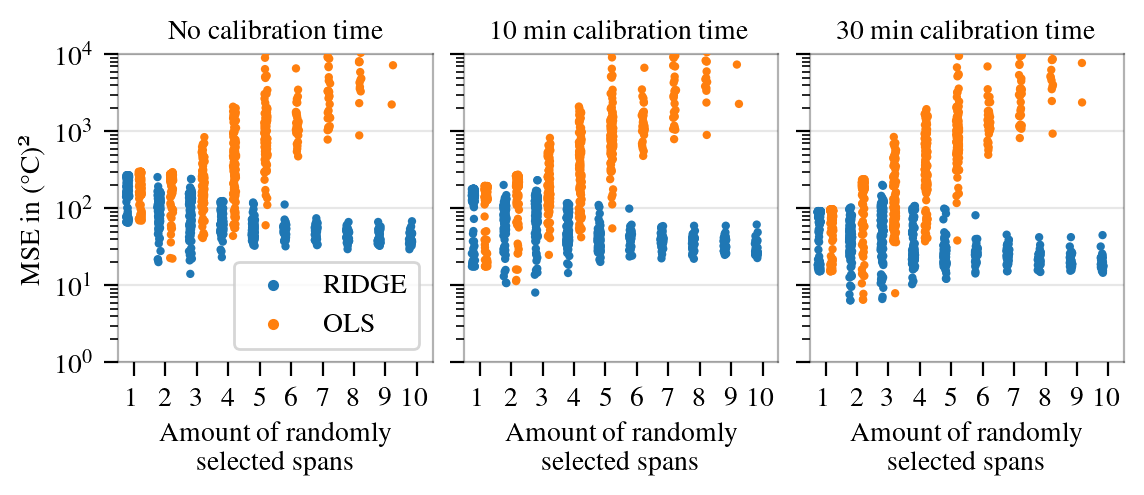

In [19]:
# strip plot
from matplotlib.ticker import LinearLocator, LogLocator

def handle_ticks(_ax):
    _ax.yaxis.set_major_locator(LogLocator(numticks=6))
    locmin = LogLocator(base=10.0,subs=np.arange(0, 1, 0.1),numticks=12)
    _ax.yaxis.set_minor_locator(locmin)
    #ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    prettify(_ax)

fig, axes = plt.subplots(1, 3, figsize=(6.49*fig_scale, 2.0*fig_scale), sharex=True, sharey=False, dpi=200)
ax = axes[0]
ax = sns.stripplot(data=ewma_study_df, x='n_spans', y='mse', hue='Model', ax=ax, dodge=True, jitter=True, size=3)
xlbl = "Amount of randomly\nselected spans"
ax.set_ylabel("MSE in (°C)²")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e4)
ax.set_yscale('log')
ax.legend(ncol=1, frameon=True, markerscale=0.5)
ax.set_title('No calibration time')
handle_ticks(ax)

ax = axes[1]
ax = sns.stripplot(data=ewma_study_df, x='n_spans', y="calibrated_mse_{CAL_1}min", hue='Model', ax=ax, dodge=True, jitter=True, size=3)
ax.set_ylabel("")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e4)
ax.set_yscale('log')
ax.get_legend().remove()
ax.set_title(f'{CAL_1} min calibration time')
handle_ticks(ax)
ax.yaxis.set_ticklabels("")

ax = axes[2]
ax = sns.stripplot(data=ewma_study_df, x='n_spans', y="calibrated_mse_{CAL_2}min", hue='Model', ax=ax, dodge=True, jitter=True, size=3)
ax.set_ylabel("")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e4)
ax.set_yscale('log')
ax.get_legend().remove()
ax.set_title(f'{CAL_2} min calibration time')
handle_ticks(ax)
ax.yaxis.set_ticklabels("")
fig.subplots_adjust(wspace=0.1)

fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_ewma_rand_search_stripplot.pdf', dpi=300, bbox_inches='tight')


In [11]:
# best spans
ewma_study_df.sort_values('mse', ascending=True).loc[:, ['experiment_id', 'Model', 'seed', 'mse', 'WorstCase', 'n_spans', 'spans']].head(10)

,experiment_id,Model,seed,mse,WorstCase,n_spans,spans
645,7480,RIDGE,0,14.127513,50.637474,3,"[10290, 699, 13570]"
772,7370,RIDGE,0,20.086502,49.189510,2,"[755, 4455]"
789,6592,RIDGE,0,21.140430,53.437096,3,"[9699, 11850, 389]"
794,7279,RIDGE,0,21.609882,59.233112,2,"[726, 6067]"
796,6543,RIDGE,0,21.922989,45.157837,2,"[2030, 3002]"
800,6638,RIDGE,0,22.272823,48.726433,3,"[13467, 774, 8447]"
801,7380,OLS,0,22.294817,49.239490,2,"[755, 4455]"
804,7289,OLS,0,22.695574,60.200660,2,"[726, 6067]"
810,6657,RIDGE,0,23.251476,57.747566,4,"[9699, 11850, 389, 11085]"
827,7390,RIDGE,0,24.750912,54.228460,3,"[8139, 10868, 373]"


In [12]:
best_model_ids = ewma_study_df.groupby('Model').apply(lambda grp: grp.loc[grp.mse == grp.mse.min(), :]).reset_index(level=1, drop=True)
best_model_ids


,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,comment,layer_cfg,spans,n_spans,Model,WorstCase,calibrated_mse_10min,calibrated_mse_30min,calibrated_mse_{CAL_1}min,calibrated_mse_{CAL_2}min
Model,,,,,,,,,,,,,,,,,,,,,
OLS,7380,2022-12-07 09:38:01,2022-12-07 09:38:06,0,22.294817,49.239490,-14.375650,7380,ols,mse,...,lin mdl analysis rand_search_ewmas,{},"[755, 4455]",2,OLS,49.239490,0,0,11.798319,6.582458
RIDGE,7480,2022-12-07 09:40:23,2022-12-07 09:40:25,0,14.127513,50.637474,-12.877159,7480,ridge,mse,...,lin mdl analysis rand_search_ewmas,{},"[10290, 699, 13570]",3,RIDGE,50.637474,0,0,8.081127,6.668133


In [13]:
kaggle_ds = KaggleDataSet()
show_mdls = ['OLS', 'RIDGE']
file_mdl_map = {'OLS': 'ols', 'RIDGE': 'ridge'}
mdl_ests = {}
for mdl, eid in best_model_ids.loc[show_mdls, 'experiment_id'].iteritems():
    est_file = BIN_PATH / f'expid_{eid}_{file_mdl_map[mdl]}_estimates.pkl.bz2'
    if not Path.exists(est_file):
        host = meta_df.query(f"experiment_id == {eid}").hostname.iloc[0]
        print(f"SecureCopy experiment {eid} from {host}")
        subprocess.run(f"scp {host}:{est_file} {est_file}", shell=True)
    mdl_est = pd.read_pickle(est_file)
    mdl_est.loc[:, kaggle_ds.target_cols] *= 100 #kaggle_ds.temperature_scale
    mdl_ests[mdl] = mdl_est



AttributeError: 'Series' object has no attribute 'iteritems'

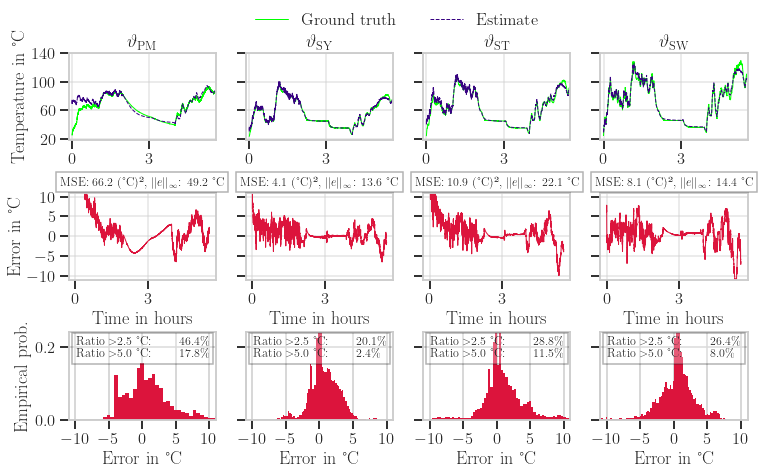

In [10]:
fig = show_error_trajectories_4_diss(mdl_ests['OLS'], dataset=kaggle_ds)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_mlp_ts.png', dpi=160, bbox_inches='tight')

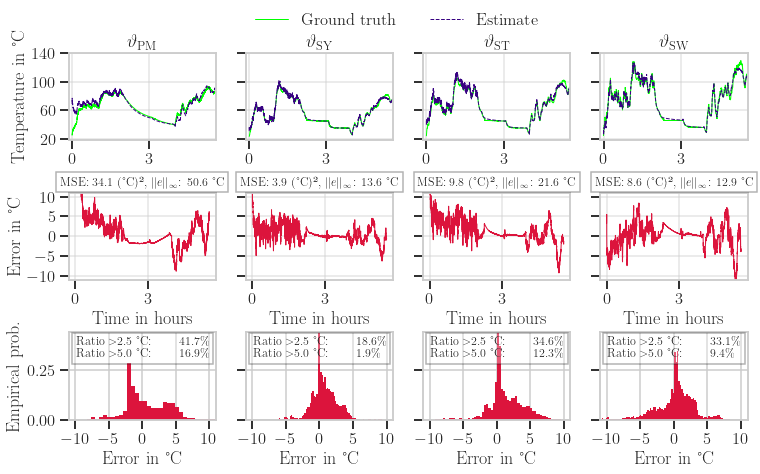

In [11]:
fig = show_error_trajectories_4_diss(mdl_ests['RIDGE'], dataset=kaggle_ds)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_gbm_ts.png', dpi=160, bbox_inches='tight')

## Regularization study

In [9]:
reg_study_df = meta_df.query("comment.str.contains('grid_search_reg_lasso_ridge')")
reg_study_df.sort_values('mse')

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,cv,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
66,7811,2022-12-09 10:37:35,2022-12-09 10:51:05,1,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
67,7811,2022-12-09 10:25:35,2022-12-09 10:37:32,0,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
68,7811,2022-12-09 10:51:09,2022-12-09 11:04:31,2,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
69,7811,2022-12-09 11:04:35,2022-12-09 11:18:33,3,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
71,7811,2022-12-09 11:18:37,2022-12-09 11:29:17,4,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
72,7811,2022-12-09 11:29:21,2022-12-09 11:41:46,5,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
73,7811,2022-12-09 11:41:50,2022-12-09 11:53:06,6,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
75,7811,2022-12-09 11:53:09,2022-12-09 12:01:23,7,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
76,7811,2022-12-09 12:01:26,2022-12-09 12:09:07,8,5.890210,21.629620,-12.232882,7811,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 4e-05}
129,7801,2022-12-08 14:28:53,2022-12-08 14:35:08,3,6.297330,17.339455,-11.864460,7801,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-skynet,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis grid_search_reg_lasso_ridge,{'alpha': 5e-05}


In [10]:
reg_study_df['alpha'] = reg_study_df.layer_cfg.str.split(':').apply(lambda x: x[-1].strip('}]')).astype(float)
reg_study_df["Model"] = reg_study_df.model_tag.str.upper().str.replace("HISTGBM", "GBM")

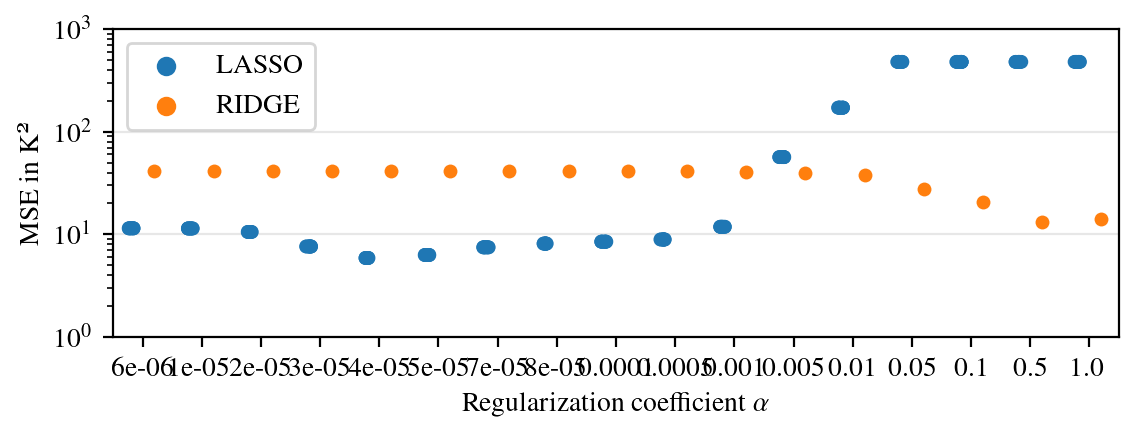

In [16]:
# strip plot
fig = plt.figure(figsize=(6.49*fig_scale, 2.0*fig_scale))
ax = fig.gca()
ax = sns.stripplot(data=reg_study_df, x='alpha', y='mse', hue='Model', ax=ax, dodge=True, jitter=True)
xlbl = "Regularization coefficient $\\alpha$"
ax.set_ylabel("MSE in K²")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e3)
ax.set_yscale('log')
ax.legend(ncol=1, frameon=True)

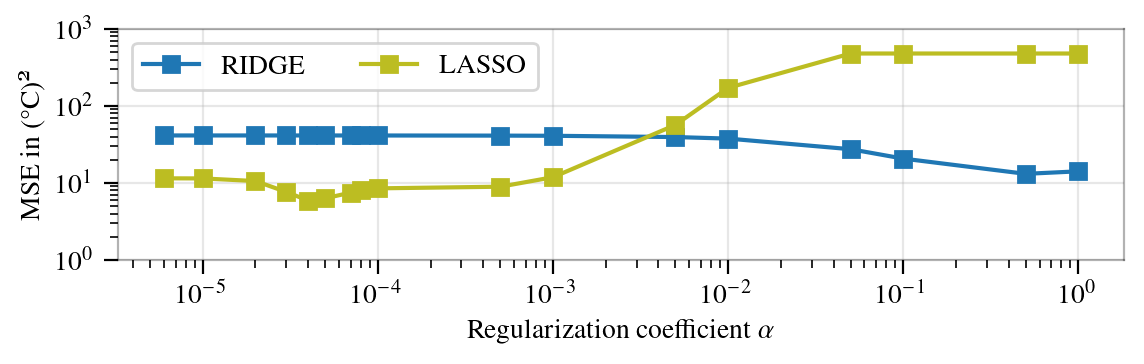

In [11]:
# line plot
fig = plt.figure(figsize=(6.49*fig_scale, 1.5*fig_scale))
ax = fig.gca()
mdl2colors = {'RIDGE': 'tab:blue', 'OLS': 'tab:orange', 'LASSO': 'tab:olive'}
filtered_reg_study_df = reg_study_df.groupby(["Model", 'alpha']).apply(lambda x: x.iloc[0])\
        .reset_index(drop=True).sort_values(by=['Model', "alpha"], ascending=[False, True])
for mdl_tag, mdl_df in filtered_reg_study_df.groupby('Model', sort=False):
    ax.plot(mdl_df.alpha, mdl_df.mse, label=mdl_tag, marker='s', color=mdl2colors[mdl_tag])
#ax = sns.stripplot(data=reg_study_df, x='alpha', y='mse', hue='Model', ax=ax, dodge=True, jitter=True)
xlbl = "Regularization coefficient $\\alpha$"
ax.set_ylabel("MSE in (°C)²")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2, frameon=True)
prettify(ax)
#fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_alpha_grid_search.pdf', dpi=300, bbox_inches='tight')


## Feature Selection Study

### VIF

In [12]:
vif_study_df = meta_df.query("comment.str.contains('vif_feat_sel')").reset_index(drop=True)
vif_study_df.sort_values('mse')

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,cv,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,7950,2022-12-16 12:33:30,2022-12-16 12:56:10,0,5.202126,9.470794,-12.294308,7950,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",160,lin mdl analysis vif_feat_sel,{'alpha': 4e-05}
1,7952,2022-12-16 12:33:31,2022-12-16 12:56:18,0,5.202145,9.470643,-12.294310,7952,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",164,lin mdl analysis vif_feat_sel,{'alpha': 4e-05}
2,7949,2022-12-16 12:33:27,2022-12-16 12:56:03,0,5.202154,9.471590,-12.294465,7949,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",156,lin mdl analysis vif_feat_sel,{'alpha': 4e-05}
3,7944,2022-12-16 12:33:24,2022-12-16 12:55:21,0,5.449487,9.293393,-12.393299,7944,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",152,lin mdl analysis vif_feat_sel,{'alpha': 4e-05}
4,7886,2022-12-16 12:33:09,2022-12-16 12:33:11,0,5.468608,48.460102,-13.999156,7886,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",164,lin mdl analysis vif_feat_sel,{'alpha': 0.5}
5,7848,2022-12-16 12:32:40,2022-12-16 12:32:55,0,5.469794,48.477340,-13.974839,7848,ols,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",164,lin mdl analysis vif_feat_sel,{}
6,7884,2022-12-16 12:33:07,2022-12-16 12:33:10,0,5.471799,37.830097,-12.972354,7884,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",156,lin mdl analysis vif_feat_sel,{'alpha': 0.5}
7,7844,2022-12-16 12:32:39,2022-12-16 12:32:52,0,5.477435,37.883205,-12.963352,7844,ols,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",156,lin mdl analysis vif_feat_sel,{}
8,7956,2022-12-16 12:33:51,2022-12-16 12:57:12,0,5.566865,22.447872,-12.125586,7956,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",200,lin mdl analysis vif_feat_sel,{'alpha': 4e-05}
9,7887,2022-12-16 12:33:09,2022-12-16 12:33:12,0,5.635803,50.069847,-14.393847,7887,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",160,lin mdl analysis vif_feat_sel,{'alpha': 0.5}


In [13]:
vif_study_df.loc[:, 'input_cols'] = vif_study_df.input_cols.str.strip("}{").str.split(',')
vif_study_df.loc[:, 'n_inp_cols'] = vif_study_df.input_cols.apply(lambda x: len(x))
vif_study_df["Model"] = vif_study_df.model_tag.str.upper()
vif_study_df.head()

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,cv,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg,n_inp_cols,Model
0,7950,2022-12-16 12:33:30,2022-12-16 12:56:10,0,5.202126,9.470794,-12.294308,7950,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"[coolant, u_d, u_q, motor_speed, i_d, i_q, i_s...","{pm,stator_yoke,stator_tooth,stator_winding}",160,lin mdl analysis vif_feat_sel,{'alpha': 4e-05},39,LASSO
1,7952,2022-12-16 12:33:31,2022-12-16 12:56:18,0,5.202145,9.470643,-12.294310,7952,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"[ambient, coolant, u_d, u_q, motor_speed, i_d,...","{pm,stator_yoke,stator_tooth,stator_winding}",164,lin mdl analysis vif_feat_sel,{'alpha': 4e-05},40,LASSO
2,7949,2022-12-16 12:33:27,2022-12-16 12:56:03,0,5.202154,9.471590,-12.294465,7949,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"[coolant, u_d, u_q, motor_speed, i_d, i_q, i_s...","{pm,stator_yoke,stator_tooth,stator_winding}",156,lin mdl analysis vif_feat_sel,{'alpha': 4e-05},38,LASSO
3,7944,2022-12-16 12:33:24,2022-12-16 12:55:21,0,5.449487,9.293393,-12.393299,7944,lasso,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"[coolant, u_d, u_q, motor_speed, i_d, i_q, i_s...","{pm,stator_yoke,stator_tooth,stator_winding}",152,lin mdl analysis vif_feat_sel,{'alpha': 4e-05},37,LASSO
4,7886,2022-12-16 12:33:09,2022-12-16 12:33:11,0,5.468608,48.460102,-13.999156,7886,ridge,mse,hpo_1fold_no_val_static_diss,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"[ambient, coolant, u_d, u_q, motor_speed, i_d,...","{pm,stator_yoke,stator_tooth,stator_winding}",164,lin mdl analysis vif_feat_sel,{'alpha': 0.5},40,RIDGE


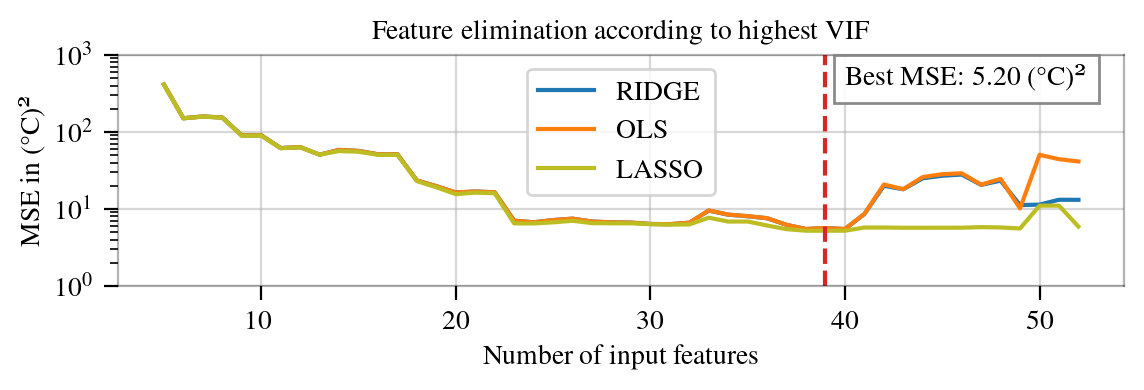

In [23]:
# line plot
fig = plt.figure(figsize=(6.49*fig_scale, 1.5*fig_scale))
ax = fig.gca()
annot_bbox_kws = {'facecolor': 'white', 'edgecolor': 'tab:grey',
                      'alpha': 0.9, 'mutation_scale': 1.2}
mdl2colors = {'RIDGE': 'tab:blue', 'OLS': 'tab:orange', 'LASSO': 'tab:olive'}
filtered_vif_study_df = vif_study_df.groupby(["Model", 'n_inp_cols']).apply(lambda x: x.iloc[0])\
        .reset_index(drop=True).sort_values(by=['Model', "n_inp_cols"], ascending=[False, True])
for mdl_tag, mdl_df in filtered_vif_study_df.groupby('Model', sort=False):
    ax.plot(mdl_df.n_inp_cols, mdl_df.mse, label=mdl_tag, color=mdl2colors[mdl_tag])
xlbl = "Number of input features"

best_n_inp_feats = vif_study_df.loc[vif_study_df.mse.argmin(), 'n_inp_cols']
ax.axvline(x=best_n_inp_feats, ls='--', color='tab:red')
ax.text(best_n_inp_feats+1, 400, f"Best MSE: {vif_study_df.mse.min():.2f} (°C)²", bbox=annot_bbox_kws)

ax.set_ylabel("MSE in (°C)²")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e3)
ax.set_yscale('log')
ax.grid(alpha=0.5)
ax.legend(ncol=1, frameon=True)
ax.set_title("Feature elimination according to highest VIF")
prettify(ax)


### RFE (Lasso)

In [24]:
rfe_study_df = meta_df.query("comment.str.contains('rfe_feat_sel')").reset_index(drop=True)
rfe_study_df.sort_values('mse')

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,scriptname,hostname,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg
0,8188,2022-12-16 16:42:32,2022-12-16 17:14:59,0,5.811468,14.221133,-14.961245,8188,lasso,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",204,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05}
1,8183,2022-12-16 16:42:37,2022-12-16 17:14:05,0,5.890210,21.629620,-12.232882,8183,lasso,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05}
2,8189,2022-12-16 16:42:39,2022-12-16 17:14:59,0,6.106092,22.214651,-13.441584,8189,lasso,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",208,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05}
3,8187,2022-12-16 16:42:31,2022-12-16 17:14:58,0,6.349247,17.522455,-14.930668,8187,lasso,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",200,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05}
4,8185,2022-12-16 16:42:29,2022-12-16 17:14:40,0,6.795648,17.507978,-15.216650,8185,lasso,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,u_d,u_q,motor_speed,i_d,i_q,i_s,u_s,S...","{pm,stator_yoke,stator_tooth,stator_winding}",196,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,8154,2022-12-16 16:57:27,2022-12-16 17:01:12,0,35.389830,24.375061,-28.766457,8154,lasso,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant_ewma_699,u_d_ewma_699,i_s_ewma_699,P_...","{pm,stator_yoke,stator_tooth,stator_winding}",24,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05}
131,8149,2022-12-16 16:57:11,2022-12-16 16:57:12,0,35.449127,24.532356,-28.799858,8149,ridge,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant_ewma_699,u_d_ewma_699,i_s_ewma_699,P_...","{pm,stator_yoke,stator_tooth,stator_winding}",24,lin mdl analysis rfe_feat_sel,{'alpha': 0.5}
132,8148,2022-12-16 16:56:54,2022-12-16 16:56:57,0,35.451270,24.532650,-28.799978,8148,ols,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{coolant_ewma_699,u_d_ewma_699,i_s_ewma_699,P_...","{pm,stator_yoke,stator_tooth,stator_winding}",24,lin mdl analysis rfe_feat_sel,{}
133,8114,2022-12-16 16:41:30,2022-12-16 16:41:52,0,41.296932,30.439870,-14.257075,8114,ols,mse,...,run_linear_analysis_4_diss.py,lea-cyberdyne,False,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rfe_feat_sel,{}


In [25]:
rfe_study_df.loc[:, 'input_cols'] = rfe_study_df.input_cols.str.strip("}{").str.split(',')
rfe_study_df.loc[:, 'n_inp_cols'] = rfe_study_df.input_cols.apply(lambda x: len(x))
rfe_study_df["Model"] = rfe_study_df.model_tag.str.upper()
rfe_study_df.head()

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,debug,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg,n_inp_cols,Model
0,8188,2022-12-16 16:42:32,2022-12-16 17:14:59,0,5.811468,14.221133,-14.961245,8188,lasso,mse,...,False,kaggle,1,"[ambient, coolant, u_d, u_q, motor_speed, i_d,...","{pm,stator_yoke,stator_tooth,stator_winding}",204,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05},50,LASSO
1,8183,2022-12-16 16:42:37,2022-12-16 17:14:05,0,5.890210,21.629620,-12.232882,8183,lasso,mse,...,False,kaggle,1,"[ambient, coolant, u_d, u_q, motor_speed, i_d,...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05},52,LASSO
2,8189,2022-12-16 16:42:39,2022-12-16 17:14:59,0,6.106092,22.214651,-13.441584,8189,lasso,mse,...,False,kaggle,1,"[ambient, coolant, u_d, u_q, motor_speed, i_d,...","{pm,stator_yoke,stator_tooth,stator_winding}",208,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05},51,LASSO
3,8187,2022-12-16 16:42:31,2022-12-16 17:14:58,0,6.349247,17.522455,-14.930668,8187,lasso,mse,...,False,kaggle,1,"[ambient, coolant, u_d, u_q, motor_speed, i_d,...","{pm,stator_yoke,stator_tooth,stator_winding}",200,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05},49,LASSO
4,8185,2022-12-16 16:42:29,2022-12-16 17:14:40,0,6.795648,17.507978,-15.216650,8185,lasso,mse,...,False,kaggle,1,"[ambient, u_d, u_q, motor_speed, i_d, i_q, i_s...","{pm,stator_yoke,stator_tooth,stator_winding}",196,lin mdl analysis rfe_feat_sel,{'alpha': 4e-05},48,LASSO


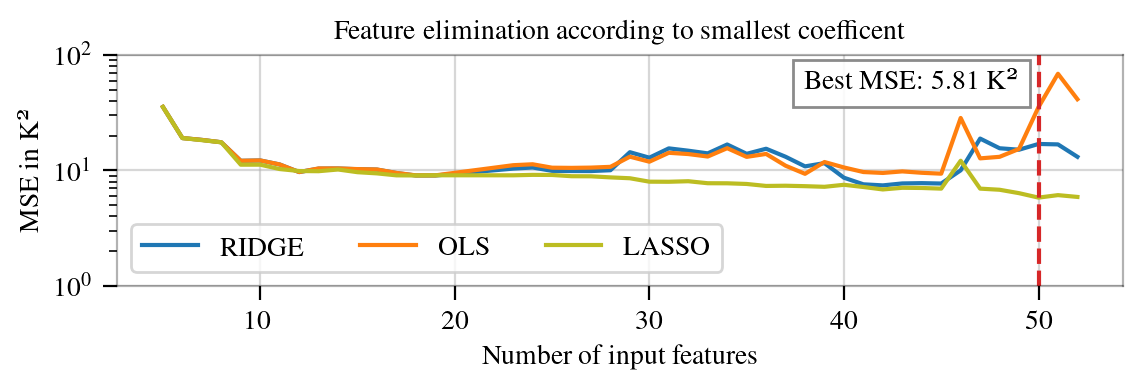

In [26]:
# line plot
fig = plt.figure(figsize=(6.49*fig_scale, 1.5*fig_scale))
ax = fig.gca()

filtered_rfe_study_df = rfe_study_df.groupby(["Model", 'n_inp_cols']).apply(lambda x: x.iloc[0])\
        .reset_index(drop=True).sort_values(by=['Model', "n_inp_cols"], ascending=[False, True])
for mdl_tag, mdl_df in filtered_rfe_study_df.groupby('Model', sort=False):
    ax.plot(mdl_df.n_inp_cols, mdl_df.mse, label=mdl_tag, color=mdl2colors[mdl_tag])
xlbl = "Number of input features"

best_n_inp_feats = rfe_study_df.loc[rfe_study_df.mse.argmin(), 'n_inp_cols']
ax.axvline(x=best_n_inp_feats, ls='--', color='tab:red')
ax.text(best_n_inp_feats-1, 50, f"Best MSE: {rfe_study_df.mse.min():.2f} K²", bbox=annot_bbox_kws,
                horizontalalignment='right')

ax.set_ylabel("MSE in K²")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e2)
ax.set_yscale('log')
ax.grid(alpha=0.5)
ax.legend(ncol=3, frameon=True)
ax.set_title("Feature elimination according to smallest coefficent")
prettify(ax)

### Both in one plot

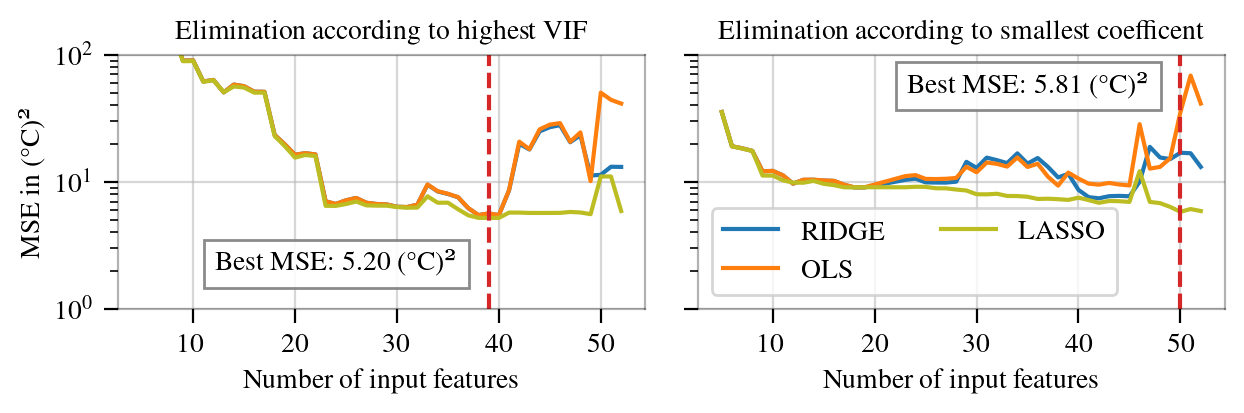

In [27]:
fig_scale = 1.1
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6.49*fig_scale, 1.5*fig_scale))
ax = axes[0]

for mdl_tag, mdl_df in filtered_vif_study_df.groupby('Model', sort=False):
    ax.plot(mdl_df.n_inp_cols, mdl_df.mse, label=mdl_tag, color=mdl2colors[mdl_tag])
xlbl = "Number of input features"
ylbl = "MSE in (°C)²"
best_n_inp_feats = vif_study_df.loc[vif_study_df.mse.argmin(), 'n_inp_cols']
ax.axvline(x=best_n_inp_feats, ls='--', color='tab:red')
ax.text(best_n_inp_feats-3, 2, f"Best MSE: {vif_study_df.mse.min():.2f} (°C)²", bbox=annot_bbox_kws,
        horizontalalignment='right')

ax.set_ylabel(ylbl)
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e2)
ax.set_yscale('log')
ax.grid(alpha=0.5)

ax.set_title("Elimination according to highest VIF")
prettify(ax)

ax = axes[1]
for mdl_tag, mdl_df in filtered_rfe_study_df.groupby('Model', sort=False):
    ax.plot(mdl_df.n_inp_cols, mdl_df.mse, label=mdl_tag, color=mdl2colors[mdl_tag])

best_n_inp_feats = rfe_study_df.loc[rfe_study_df.mse.argmin(), 'n_inp_cols']
ax.axvline(x=best_n_inp_feats, ls='--', color='tab:red')
ax.text(best_n_inp_feats-3, 50, f"Best MSE: {rfe_study_df.mse.min():.2f} (°C)²", bbox=annot_bbox_kws,
        horizontalalignment='right')

ax.set_xlabel(xlbl)
#ax.set_ylim(1, 1e2)
#ax.set_yscale('log')
ax.grid(alpha=0.5)

ax.legend(ncol=2, frameon=True)
ax.set_title("Elimination according to smallest coefficent")
prettify(ax)
fig.subplots_adjust(wspace=0.1)

fig.savefig(IMG_PATH / 'diss_ests_static_blackbox_vif_rfe.pdf', dpi=300, bbox_inches='tight')


In [62]:
# which features are the best for LASSO? Should be 39
best_exp = vif_study_df.loc[:, ['mse', 'n_inp_cols', 'input_cols']].iloc[0]
print(best_exp)
best_input_cols = best_exp.input_cols
assert(len(best_input_cols) == best_exp.n_inp_cols)
best_input_cols

mse                                                    5.202126
n_inp_cols                                                   39
input_cols    [coolant, u_d, u_q, motor_speed, i_d, i_q, i_s...
Name: 0, dtype: object


['coolant',
 'u_d',
 'u_q',
 'motor_speed',
 'i_d',
 'i_q',
 'i_s',
 'u_s',
 'S_el',
 'P_el',
 'i_s_x_w',
 'S_x_w',
 'coolant_ewma_10290',
 'u_d_ewma_10290',
 'u_q_ewma_10290',
 'i_q_ewma_10290',
 'i_s_ewma_10290',
 'S_el_ewma_10290',
 'S_x_w_ewma_10290',
 'coolant_ewma_699',
 'u_d_ewma_699',
 'u_q_ewma_699',
 'i_d_ewma_699',
 'i_q_ewma_699',
 'i_s_ewma_699',
 'u_s_ewma_699',
 'S_el_ewma_699',
 'P_el_ewma_699',
 'S_x_w_ewma_699',
 'ambient_ewma_13570',
 'coolant_ewma_13570',
 'u_d_ewma_13570',
 'u_q_ewma_13570',
 'i_d_ewma_13570',
 'i_q_ewma_13570',
 'i_s_ewma_13570',
 'u_s_ewma_13570',
 'P_el_ewma_13570',
 'i_s_x_w_ewma_13570']

## Train set size study

In [3]:
set_size_study_df = meta_df.query("comment.str.contains('trainset_size')").reset_index(drop=True)
set_size_study_df["size_divisor"] = set_size_study_df.comment.str.extract(r'd_=(\w+)').astype(int)
set_size_study_df["rep"] = set_size_study_df.comment.str.extract(r'r_=(\w+)').astype(int)
set_size_study_df["Model"] = set_size_study_df.model_tag.str.upper()
set_size_study_df = set_size_study_df.sort_values('size_divisor', ascending=True).reset_index(drop=True)
set_size_study_df

,experiment_id,started_at,finished_at,seed,mse,l_infty_over,l_infty_under,id,model_tag,loss,...,dataset,n_folds,input_cols,target_cols,model_size,comment,layer_cfg,size_divisor,rep,Model
0,30420,2023-01-02 21:48:46,2023-01-02 21:50:34,0,4.158362,12.008837,-7.946434,30420,lasso,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 4e-05},1,0,LASSO
1,30504,2023-01-02 21:55:13,2023-01-02 21:57:46,0,100.432220,10.630784,-37.830734,30504,lasso,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 4e-05},1,0,LASSO
2,30464,2023-01-02 21:54:36,2023-01-02 21:54:36,0,91.820580,75.993710,-43.406322,30464,ridge,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 0.5},1,0,RIDGE
3,30499,2023-01-02 21:57:40,2023-01-02 21:57:40,0,82.349130,26.028680,-36.114140,30499,ridge,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 0.5},1,0,RIDGE
4,30410,2023-01-02 21:49:38,2023-01-02 21:49:38,0,81.631744,41.687070,-50.242306,30410,ridge,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 0.5},1,0,RIDGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,33042,2023-01-04 14:36:18,2023-01-04 14:36:24,0,10.829139,37.715990,-14.312647,33042,ridge,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 0.5},9,6,RIDGE
1349,33068,2023-01-04 14:45:30,2023-01-04 14:46:03,0,32.680190,34.844420,-24.263298,33068,ols,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{},9,16,OLS
1350,28791,2023-01-02 15:00:54,2023-01-02 15:40:41,0,5.883133,21.545370,-12.233211,28791,lasso,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 4e-05},10,0,LASSO
1351,28712,2023-01-02 15:00:38,2023-01-02 15:00:42,0,13.104724,47.347168,-13.093171,28712,ridge,mse,...,kaggle,1,"{ambient,coolant,u_d,u_q,motor_speed,i_d,i_q,i...","{pm,stator_yoke,stator_tooth,stator_winding}",212,lin mdl analysis rand_search_trainset_size d_=...,{'alpha': 0.5},10,0,RIDGE


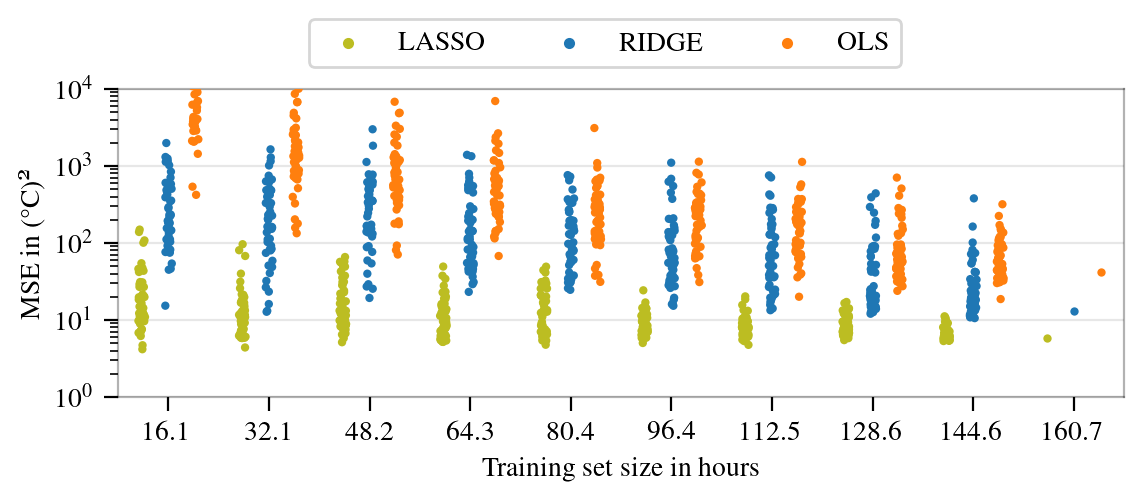

In [4]:
# strip plot
from matplotlib.ticker import LogLocator

fig_scale = 1.0
mdl2colors = {'RIDGE': 'tab:blue', 'OLS': 'tab:orange', 'LASSO': 'tab:olive'}
fig = plt.figure(figsize=(6.49*fig_scale, 2.0*fig_scale), dpi=200)
ax = fig.gca()

full_training_set_size = 1157138
ax = sns.stripplot(data=set_size_study_df, x='size_divisor', y='mse', hue='Model',
                   palette=[mdl2colors[m] for m in set_size_study_df.Model.unique().tolist()],
                   ax=ax, dodge=True, jitter=True, order=pd.Series(range(1,11)), size=3)
xlbl = "Training set size in hours"
ax.set_ylabel("MSE in (°C)²")
ax.set_xlabel(xlbl)
ax.set_ylim(1, 1e4)
ax.set_yscale('log')
ax.legend(ncol=3, frameon=True, markerscale=0.5,
          loc='lower center', bbox_to_anchor=(.5, 0.9),
          # axes[0, 1].transAxes
          bbox_transform=fig.transFigure
          )
# ax.set_title('No calibration time')
ax.set_xticklabels([f"{full_training_set_size / 7200 *0.1 * i:.1f}" for i in range(1, 11)])
#ax.grid(alpha=0.5)
ax.yaxis.set_major_locator(LogLocator(numticks=6))
locmin = LogLocator(base=10.0,subs=np.arange(0, 1, 0.1),numticks=12)
ax.yaxis.set_minor_locator(locmin)
prettify(ax)

fig.savefig(IMG_PATH / 'diss_ests_lin_mdl_train_set_size.pdf', dpi=300, bbox_inches='tight')